### 1. Load Train / Test / Validation Data Files

In [1]:
import numpy as np

In [2]:
train_features_path =  "../feature/ICDAR-feature/train_features_triplet_loss.npy"
train_names_path = "../feature/ICDAR-feature/train_names.npy"
train_labels_path = "../feature/ICDAR-feature/train_labels.npy"

test_features_path = "../feature/ICDAR-feature/test_features_triplet_loss.npy"
test_names_path = "../feature/ICDAR-feature/test_names.npy"
test_labels_path = "../feature/ICDAR-feature/test_labels.npy"

validation_features_path = "../feature/ICDAR-feature/validation_features_triplet_loss.npy"
validation_names_path = "../feature/ICDAR-feature/validation_names.npy"
validation_labels_path = "../feature/ICDAR-feature/validation_labels.npy"

gallery_feature_path = "../feature/ICDAR-feature/gallery_features_triplet_loss.npy"
gallery_name_path = "../feature/ICDAR-feature/gallery_names.npy"

train_features = np.load(train_features_path)
train_names = np.load(train_names_path)
train_labels = np.load(train_labels_path)

test_features = np.load(test_features_path)
test_names = np.load(test_names_path)
test_labels = np.load(test_labels_path)

validation_features = np.load(validation_features_path)
validation_names = np.load(validation_names_path)
validation_labels = np.load(validation_labels_path)

gallery_features = np.load(gallery_feature_path)
gallery_names = np.load(gallery_name_path)

In [3]:
print(train_features.shape)
print(train_labels.shape)
print(train_names.shape)
print(test_features.shape)
print(test_labels.shape)
print(test_names.shape)
print(validation_features.shape)
print(validation_labels.shape)
print(validation_names.shape)
print(gallery_features.shape)
print(gallery_names.shape)

(857, 512)
(857,)
(857,)
(401, 512)
(401,)
(401,)
(391, 512)
(391,)
(391,)
(64, 512)
(64,)


In [4]:
def find_difference_vector(vector_features, vector_labels, vector_names, gallery_features, gallery_names):
    difference_vectors = []
    difference_names = []
    difference_labels = []

    for gallery_feature, gallery_name in zip(gallery_features, gallery_names):
        curr_difference_name = gallery_name
        curr_difference_feature = []
        curr_difference_label = []
        curr_difference = []
        
        for feature, name, label in zip(vector_features, vector_names, vector_labels):
            # print(f"Gallery Name: {gallery_name}, Name: {name}")
            if gallery_name == name:
                curr_difference_feature.append(feature)
                curr_difference_label.append(label)
        
        if curr_difference_feature:  # Check if the list is not empty
            # Assuming curr_difference_feature, curr_difference_label, and gallery_feature are numpy arrays
            curr_difference_feature = np.array(curr_difference_feature)
            curr_difference_label = np.array(curr_difference_label)
            curr_difference = curr_difference_feature - gallery_feature

            difference_vectors.append(curr_difference)
            difference_names.append(curr_difference_name)
            difference_labels.append(curr_difference_label)
            
    return difference_vectors, difference_names, difference_labels

In [5]:
test_difference_vectors, test_difference_names, test_difference_labels = find_difference_vector(test_features, test_labels, test_names, gallery_features, gallery_names)
train_difference_vectors, train_difference_names, train_difference_labels = find_difference_vector(train_features, train_labels, train_names, gallery_features, gallery_names)
validation_difference_vectors, validation_difference_names, validation_difference_labels = find_difference_vector(validation_features, validation_labels, validation_names, gallery_features, gallery_names)

### 2. Train on ML

In [6]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [7]:
# For Train Set
train_difference_vectors_flat = [item for sublist in train_difference_vectors for item in sublist]
train_difference_array = np.array(train_difference_vectors_flat).reshape(len(train_difference_vectors_flat), -1)

# For test set
test_difference_vectors_flat = [item for sublist in test_difference_vectors for item in sublist]
test_difference_array = np.array(test_difference_vectors_flat).reshape(len(test_difference_vectors_flat), -1)

# For validation set
validation_difference_vectors_flat = [item for sublist in validation_difference_vectors for item in sublist]
validation_difference_array = np.array(validation_difference_vectors_flat).reshape(len(validation_difference_vectors_flat), -1)

In [8]:
print(train_difference_array.shape)
print(train_labels.shape)
print(test_difference_array.shape)
print(test_labels.shape)
print(validation_difference_array.shape)
print(validation_labels.shape)

(857, 512)
(857,)
(401, 512)
(401,)
(391, 512)
(391,)


In [9]:
model = svm.SVC()
model.fit(train_difference_array, train_labels)

SVC()

### 3. Hyperparameter Tuning

In [10]:
parameter = model.get_params()
for key, value in parameter.items():
    print(f"{key}: {value}")

C: 1.0
break_ties: False
cache_size: 200
class_weight: None
coef0: 0.0
decision_function_shape: ovr
degree: 3
gamma: scale
kernel: rbf
max_iter: -1
probability: False
random_state: None
shrinking: True
tol: 0.001
verbose: False


In [11]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['linear', 'rbf']}
grid_search = GridSearchCV(svm.SVC(), param_grid, cv=5)
grid_search.fit(validation_difference_array, validation_labels)
best_params = grid_search.best_params_

In [12]:
print(best_params)

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


### 4. Test

In [13]:
best_model = svm.SVC(**best_params)
best_model.fit(train_difference_array , train_labels)
test_pred = best_model.predict(test_difference_array)
accuracy = accuracy_score(test_labels, test_pred)

In [14]:
print(accuracy)

0.912718204488778


### 5. ROC Curve

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

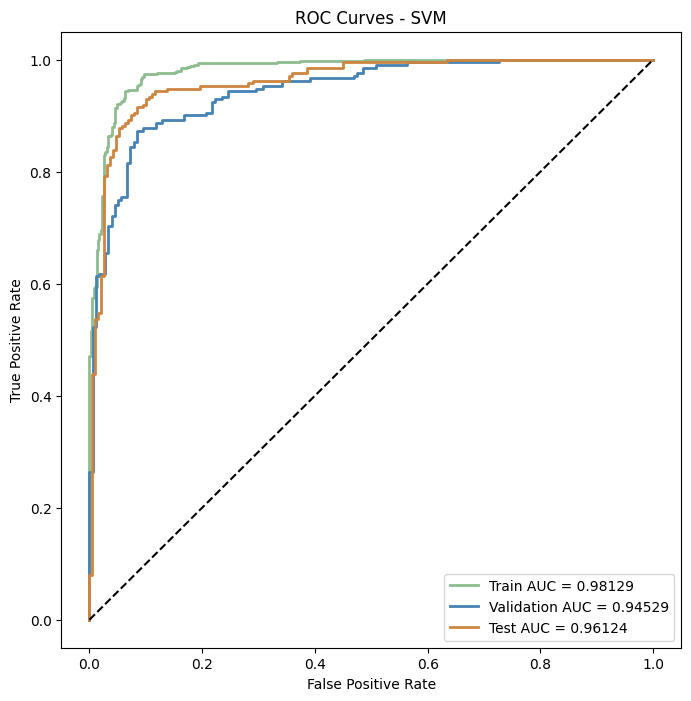

In [16]:
# Predict decision values for each class
y_train_score = best_model.decision_function(train_difference_array)
y_test_score = best_model.decision_function(test_difference_array)
y_val_score = best_model.decision_function(validation_difference_array)

# Compute ROC curve and AUC for each set
fpr_train, tpr_train, thresholds_train = roc_curve(train_labels, y_train_score, drop_intermediate=False)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, thresholds_test = roc_curve(test_labels, y_test_score, drop_intermediate=False)
roc_auc_test = auc(fpr_test, tpr_test)
fpr_val, tpr_val, thresholds_val = roc_curve(validation_labels, y_val_score, drop_intermediate=False)
roc_auc_val = auc(fpr_val, tpr_val)

# Plot ROC curve
plt.figure(figsize=(8, 8))

plt.plot(fpr_train, tpr_train, color='darkseagreen', lw=2, label=f'Train AUC = {roc_auc_train:.5f}')
plt.plot(fpr_val, tpr_val, color='steelblue', lw=2, label=f'Validation AUC = {roc_auc_val:.5f}')
plt.plot(fpr_test, tpr_test, color='peru', lw=2, label=f'Test AUC = {roc_auc_test:.5f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - SVM')
plt.legend()
plt.show()

In [17]:
def find_tpr_at_fpr(fpr, tpr, target_fpr):
    return np.interp(target_fpr, fpr, tpr)

In [18]:
target_fprs = [0.1, 0.01, 0.001]
tpr_at_target_fpr_train = [find_tpr_at_fpr(fpr_train, tpr_train, fpr) for fpr in target_fprs]
tpr_at_target_fpr_test = [find_tpr_at_fpr(fpr_test, tpr_test, fpr) for fpr in target_fprs]
tpr_at_target_fpr_val = [find_tpr_at_fpr(fpr_val, tpr_val, fpr) for fpr in target_fprs]

In [19]:
print(tpr_test)

[0.         0.00471698 0.00943396 0.01415094 0.01886792 0.02358491
 0.02830189 0.03301887 0.03773585 0.04245283 0.04716981 0.05188679
 0.05660377 0.06132075 0.06603774 0.07075472 0.0754717  0.08018868
 0.08018868 0.08490566 0.08962264 0.09433962 0.0990566  0.10377358
 0.10849057 0.11320755 0.11792453 0.12264151 0.12735849 0.13207547
 0.13679245 0.14150943 0.14622642 0.1509434  0.15566038 0.16037736
 0.16509434 0.16981132 0.1745283  0.17924528 0.18396226 0.18867925
 0.19339623 0.19811321 0.20283019 0.20754717 0.21226415 0.21698113
 0.22169811 0.22641509 0.23113208 0.23584906 0.24056604 0.24528302
 0.25       0.25471698 0.25943396 0.26415094 0.26886792 0.27358491
 0.27830189 0.28301887 0.28773585 0.29245283 0.29716981 0.30188679
 0.30660377 0.31132075 0.31603774 0.32075472 0.3254717  0.33018868
 0.33490566 0.33962264 0.34433962 0.3490566  0.35377358 0.35849057
 0.36320755 0.36792453 0.37264151 0.37735849 0.38207547 0.38679245
 0.39150943 0.39622642 0.4009434  0.40566038 0.41037736 0.4150

In [20]:
print(fpr_test)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00529101 0.00529101 0.00529101 0.00529101 0.00529101 0.00529101
 0.00529101 0.00529101 0.00529101 0.00529101 0.00529101 0.00529101
 0.00529101 0.00529101 0.00529101 0.00529101 0.00529101 0.00529101
 0.00529101 0.00529101 0.00529101 0.00529101 0.00529101 0.00529101
 0.00529101 0.00529101 0.00529101 0.00529101 0.00529101 0.00529101
 0.00529101 0.00529101 0.00529101 0.00529101 0.00529101 0.00529101
 0.00529101 0.00529101 0.00529101 0.00529101 0.00529101 0.00529101
 0.00529101 0.00529101 0.00529101 0.00529101 0.00529101 0.00529101
 0.00529101 0.00529101 0.00529101 0.00529101 0.00529101 0.00529101
 0.00529101 0.00529101 0.00529101 0.00529101 0.00529101 0.00529101
 0.00529101 0.00529101 0.00529101 0.00529101 0.00529101 0.00529101
 0.00529101 0.00529101 0.00529101 0.00529101 0.00529101 0.00529101
 0.00529101 0.00529

In [21]:
print("Train")
for tpr, fpr in zip(tpr_at_target_fpr_train, target_fprs):
    print(f'TPR at FPR {fpr:.3f}: {tpr:.3f}')
print(f'             AUC: {roc_auc_train}')

print("Validation")
for tpr, fpr in zip(tpr_at_target_fpr_val, target_fprs):
    print(f'TPR at FPR {fpr:.3f}: {tpr:.3f}')
print(f'             AUC: {roc_auc_val}')

print("Test")
for tpr, fpr in zip(tpr_at_target_fpr_test, target_fprs):
    print(f'TPR at FPR {fpr:.3f}: {tpr:.3f}')
print(f'             AUC: {roc_auc_test}')

Train
TPR at FPR 0.100: 0.974
TPR at FPR 0.010: 0.592
TPR at FPR 0.001: 0.471
             AUC: 0.9812906338051333
Validation
TPR at FPR 0.100: 0.877
TPR at FPR 0.010: 0.524
TPR at FPR 0.001: 0.264
             AUC: 0.9452935596078844
Test
TPR at FPR 0.100: 0.920
TPR at FPR 0.010: 0.439
TPR at FPR 0.001: 0.080
             AUC: 0.9612408904861736
